## 2024 La Nina Cruise Mixing Analysis<br>
This notebook details our process for calculating Richardson numbers, Thorpe Scales, and Turbulent Dissipation Rates for the 2024 El Nino Cruise<br>
Note that this notebook utilizes both code from Susan Hautala, code inspired by ChatGPT, and code from https://mixsea.readthedocs.io/en/v0.1.2/thorpe_scales.html

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import pandas as pd
import xarray as xr
import math
import gsw

import mixsea as mx

In [2]:
mpl.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.labelsize': 14,      # Font size for axis labels
    'axes.titlesize': 16,      # Font size for titles
    'xtick.labelsize': 12,     # Font size for x-axis ticks
    'ytick.labelsize': 12,     # Font size for y-axis ticks
    'legend.fontsize': 12,     # Font size for legend
    'figure.titlesize': 18     # Font size for figure titles
})

### Let's load ADCP and CTD data

In [3]:
# Load ADCP Data
datadir = 'data/2024/adcp/'
filepath_adcp = datadir+'2024_os75nb_cleaned.nc'
ADCP = xr.open_dataset(filepath_adcp, decode_times=False)

# Load CTD Cast Data
datadir = 'data/2024/ctd/cleaned/'
filepath_P = 'P.csv' # pressure
filepath_T = 'T.csv' # temperature
filepath_S = 'S.csv' # salinity
filepath_D = 'D.csv' # density
filepath_coords = 'coords.csv' # coords

P = pd.read_csv(datadir + filepath_P)
T = pd.read_csv(datadir + filepath_T)
S = pd.read_csv(datadir + filepath_S)
D = pd.read_csv(datadir + filepath_D)

coords = pd.read_csv(datadir + filepath_coords)
latitudes = coords.T[0].values

# Load Interpolated CTD Data
datadir = 'data/2024/ctd/cleaned/interpolated dataframes/'
filepath_P_int = 'P_int.csv' # pressure
filepath_T_int = 'T_int.csv' # temperature
filepath_S_int = 'S_int.csv' # salinity
filepath_D_int = 'D_int.csv' # density
filepath_lat = 'lat_df.csv' # latitude matrix

P_int = pd.read_csv(datadir + filepath_P_int)
T_int = pd.read_csv(datadir + filepath_T_int)
S_int = pd.read_csv(datadir + filepath_S_int)
D_int = pd.read_csv(datadir + filepath_D_int)
lat_matrix = pd.read_csv(datadir + filepath_lat)

### Calculate Thorpe Scales and Epsilon:
### $L_T = \sqrt{\overline{d^2}}$
### $\varepsilon = C_0 \cdot L_T^2 \cdot N^3 $
#### $ N = \sqrt{\frac{g}{\rho_0} \frac{\partial \rho}{\partial z}} $

### $ R_i = \frac{N^2}{S^2}$
### $ S = \frac{\partial u}{\partial z}$

In [4]:
def bin_average(list, num_bins): # a sub_function that bin-averages a list of data
    _, bin_edges = np.histogram(np.arange(len(list)), bins=num_bins) # bin data
    b_avg = [np.mean(list[int(start):int(end)]) for start, end in zip(bin_edges[:-1], bin_edges[1:])] # avg data by bin
    return b_avg


def df_bin_average(df, num_bins):
    binned_data = {}
    for column_idx in df.columns:
        binned_data[column_idx] = bin_average(np.array(df[column_idx]), num_bins)

    return pd.DataFrame(binned_data)


# vertical binning
num_bins = int(40)
P_bin_y = df_bin_average(P_int, num_bins)
T_bin_y = df_bin_average(T_int, num_bins)
S_bin_y = df_bin_average(S_int, num_bins)
D_bin_y = df_bin_average(D_int, num_bins)
lat_bin_y = df_bin_average(lat_matrix, num_bins)


# horizontal binning
num_bins = int(650)
P_binned = df_bin_average(P_bin_y.T, num_bins).T
T_binned = df_bin_average(T_bin_y.T, num_bins).T
S_binned = df_bin_average(S_bin_y.T, num_bins).T
D_binned = df_bin_average(D_bin_y.T, num_bins).T
lat_binned = df_bin_average(lat_bin_y.T, num_bins).T

# adcp
u = pd.DataFrame(ADCP['u'])
v = pd.DataFrame(ADCP['v'])
z = pd.DataFrame(ADCP['z'])

num_bins = int(650)
u_binned = df_bin_average(u.T, num_bins).T
v_binned = df_bin_average(v.T, num_bins).T
z_binned = df_bin_average(z.T, num_bins).T


C:\Users\Openo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Openo\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# parameters
dnoise = 5e-4  # Noise parameter
alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = np.NaN
# Use the intermediate profile method for a full resolution cast
use_ip = True
# Critical value of the overturn ratio, default in package set to 0.3
# From the code: An overturn will be considered noise if Ro < Roc.
# Ro = min(L+/L, L-/L), or percentage of space occupied by positive and negative displacements
# This has to do with whether or not the overturn is encountered vertically and so perfectly measured
# in that case Ro = 0.5, or sampled obliquely so that Ro < 0.5
# See Gargett and Garner (2008) who suggest 0.2
Roc = 0.2
# N2 Calculation Method
N2_method = "endpt"

# Some type conversion, just in case
depth = np.array(P['TN4270301d_val']).astype(float)
t = np.array(T['TN4270301d_val']).astype(float)
SP = np.array(S['TN4270301d_val']).astype(float)
lon = float(167)
lat = float(lat_matrix['0'][0])


# Calculate Thorpe scales and diagnostics.
eps, N2, diag = mx.overturn.eps_overturn(
    depth,
    t,
    SP,
    lon,
    lat,
    dnoise=dnoise,
    alpha=alpha,
    Roc=Roc,
    background_eps=background_eps,
    use_ip=use_ip,
    N2_method = N2_method,
    return_diagnostics=True
)

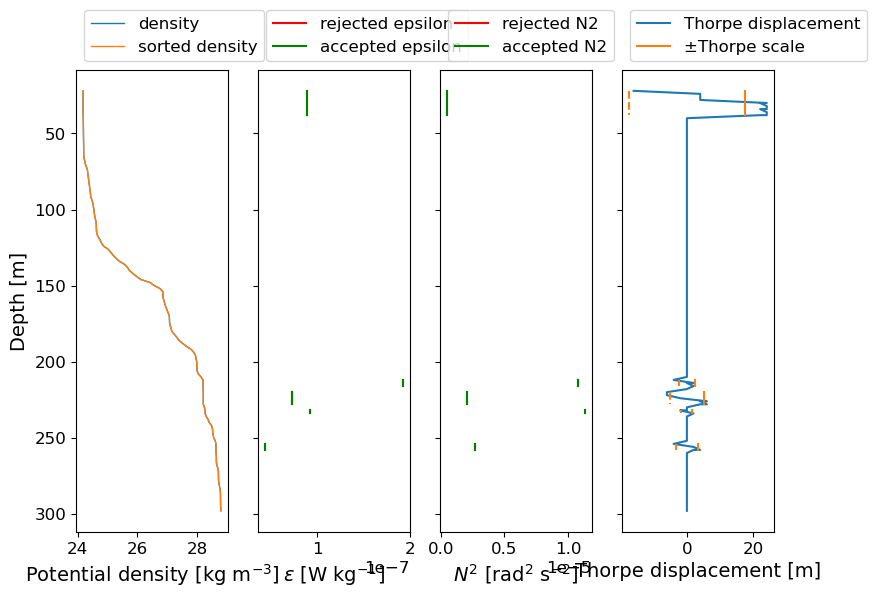

In [6]:
# Plot only in the depth range:
cut = (depth > 20) & (depth < 300)
zc = depth[cut]

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(9, 6))

#axs[0].set_ylim(150, 250)
#axs[1].set_ylim(150, 250)
#axs[2].set_ylim(150, 250)
#axs[3].set_ylim(150, 250)

axs[0].plot(diag["dens"][cut]-1000, zc, label="density", lw=1.)
axs[0].plot(diag["dens_sorted"][cut]-1000, zc, label="sorted density", lw=1.)
axs[1].plot(diag["eps"][cut], zc, label="rejected epsilon", color="r")
axs[1].plot(eps[cut], zc, label="accepted epsilon", color="g")
axs[2].plot(diag["N2"][cut], zc, label="rejected N2", color="r")
axs[2].plot(N2[cut], zc, label="accepted N2", color="g")
axs[3].plot(diag["thorpe_disp"][cut], zc, label="Thorpe displacement")
axs[3].plot(diag["Lt"][cut], zc, label="±Thorpe scale")
axs[3].plot(-diag["Lt"][cut], zc, "C1--")
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[1].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[2].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[3].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Potential density [kg m$^{-3}$]")
axs[1].set_xlabel(r"$\epsilon$ [W kg$^{-1}$]")
axs[2].set_xlabel(r"$N^2$ [rad$^2$ s$^{-2}$]")
axs[3].set_xlabel("Thorpe displacement [m]")

fig.align_labels()

In [7]:
# set some parameters
dnoise = 5e-4  # Noise parameter
alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = 0
# Use the intermediate profile method for a full resolution cast
use_ip = True
# Critical value of the overturn ratio, default in package set to 0.3
# From the code: An overturn will be considered noise if Ro < Roc.
# Ro = min(L+/L, L-/L), or percentage of space occupied by positive and negative displacements
# This has to do with whether or not the overturn is encountered vertically and so perfectly measured
# in that case Ro = 0.5, or sampled obliquely so that Ro < 0.5
# See Gargett and Garner (2008) who suggest 0.2
Roc = 0.2
# N2 Calculation Method
N2_method = "endpt"

lon = float(167)

# set up empty dataframes:
epsilon_list = []
N2_th_list = []
thorpe_list = []
dens_inv_list = []
thorpe_scale_list = []

# iterate through mixsea calculations, appending to new dataframes
cast_num = 0
for cast in P:
    depth = np.array(P[cast]).astype(float)
    t = np.array(T[cast]).astype(float)
    SP = np.array(S[cast]).astype(float)
    lat = (latitudes[cast_num])
    cast_num += 1

    # Calculate Thorpe scales and diagnostics.
    eps, N2_th, diag = mx.overturn.eps_overturn(
        depth,
        t,
        SP,
        lon,
        lat,
        dnoise=dnoise,
        alpha=alpha,
        Roc=Roc,
        background_eps=background_eps,
        use_ip=use_ip,
        N2_method = N2_method,
        return_diagnostics=True
    )
    # clean
    #thorpe = np.where(thorpe > 50, np.nan, thorpe)

    
    # append to lists
    epsilon_list.append(pd.DataFrame({cast: eps}))
    thorpe_list.append(pd.DataFrame({cast: diag["thorpe_disp"]}))
    N2_th_list.append(pd.DataFrame({cast: N2_th}))
    dens_inv_list.append(pd.DataFrame({cast: np.array(diag["dens"]) - np.array(diag["dens_sorted"])}))
    thorpe_scale_list.append(pd.DataFrame({cast: diag["Lt"]}))
    
# concat
eps = pd.concat(epsilon_list, axis = 1)
N2_th = pd.concat(N2_th_list, axis = 1)
thorpe = pd.concat(thorpe_list, axis = 1)
dens_inv = pd.concat(dens_inv_list, axis = 1)
thorpe_scale = pd.concat(thorpe_scale_list, axis = 1)

In [9]:
mask = eps > 0
eps_count = np.sum(np.sum(mask))
print('epsilon count 2024:')
print(eps_count)

mask = eps > 1*10**-7
eps_count = np.sum(np.sum(mask))
print('epsilon > 10^-7 2024:')
print(eps_count)

epsilon count 2024:
466
epsilon > 10^-7 2024:
211


In [38]:
depth_values = P['TN4270301d_val'].values
np.shape(depth_values)

(500,)

In [39]:
np.shape(thorpe)

(500, 13)

In [97]:
thorpe_displacements = []
thorpe_lats = []
thorpe_depths = []
count = 0
for col in thorpe:
    depth_count = 0
    for val in thorpe[col].values:
        if val > 0:
            thorpe_displacements.append(val)
            thorpe_lats.append(round(latitudes[count],1))
            thorpe_depths.append(depth_values[depth_count])
        depth_count += 1
    count += 1

In [107]:
epsilon = []
eps_lats = []
eps_depths = []
count = 0



for col in eps:
    depth_count = 0
    for val in eps[col].values:
        if val > 0:
            epsilon.append(val)
            eps_lats.append(round(latitudes[count],1))
            eps_depths.append(depth_values[depth_count])
        depth_count += 1
    count += 1

In [87]:
colors = []
color1, color2 = 'red', 'blue'
num_elements = len(thorpe_depths)

for i in range(num_elements):
    if i % 2 == 0:
        colors.append(color1)
    else:
        colors.append(color2)
        
widths = []
width1, width2 = 0.25, 0.5

for i in range(num_elements):
    if i % 2 == 0:
        widths.append(width1)
    else:
        widths.append(width2)

In [163]:
max(epsilon)

1.49816753017721e-06

In [164]:
np.log(max(epsilon))

-13.411267843223076

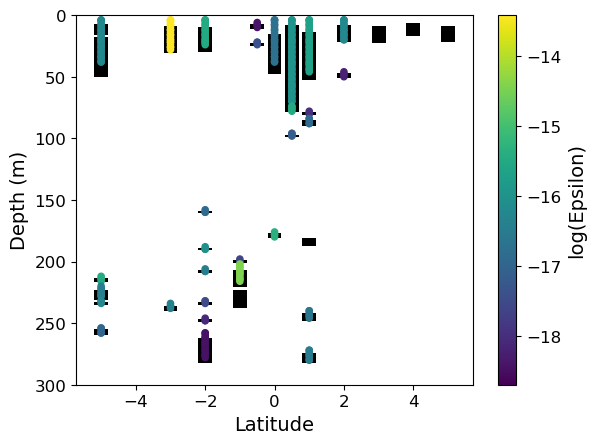

In [157]:
fig, ax = plt.subplots()

ax.bar(thorpe_lats, thorpe_displacements, width = 0.4, bottom = thorpe_depths - np.array(thorpe_displacements)/2, color = 'black')
sc = ax.scatter(eps_lats, eps_depths,c = np.log(epsilon), cmap='viridis', marker='o',s = 20)
#ax.axhline(y=50, color='black', linestyle='--')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')

cbar = plt.colorbar(sc)
cbar.set_label('log(Epsilon)')

#ax.axhline(y=140, color='blue', linewidth = 1)
#ax.axhline(y=115, color='black', linestyle='--', linewidth = 1)
ax.set_ylim(0,300)
#ax.set_title('Thorpe Displacement vs. Latitude')
ax.invert_yaxis()
plt.savefig('Thorpe_2024.png', dpi=300, bbox_inches='tight')

plt.show()

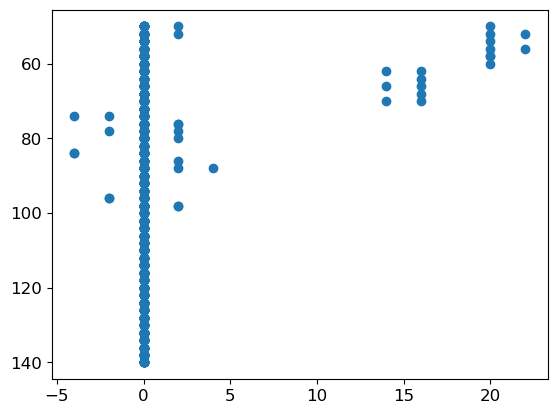

In [187]:
plt.scatter(thorpe_sel,P_sel)
plt.gca().invert_yaxis()


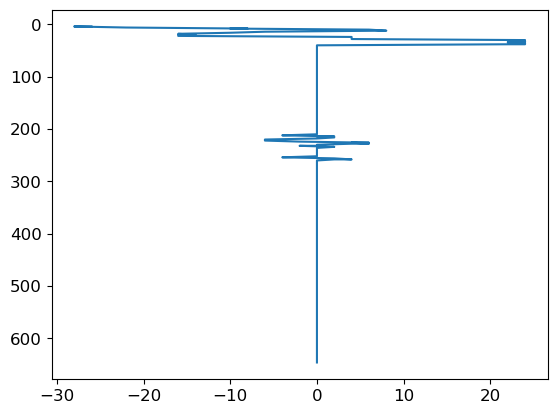

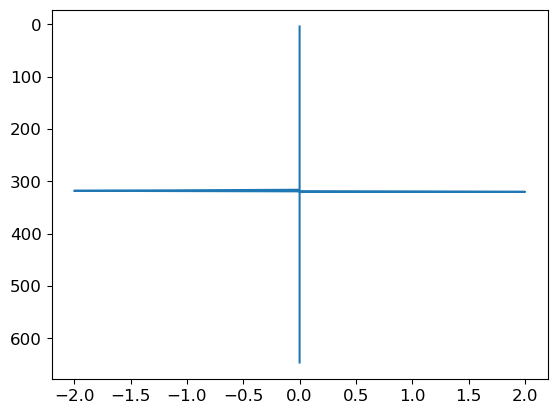

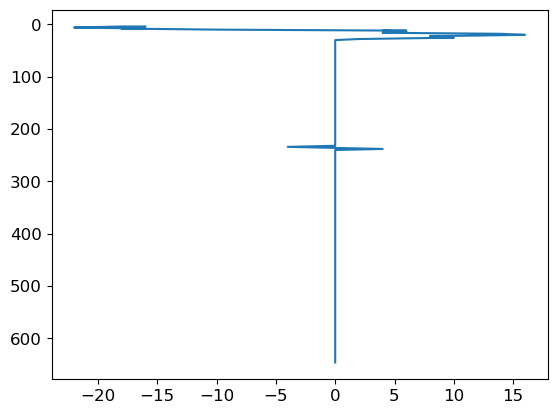

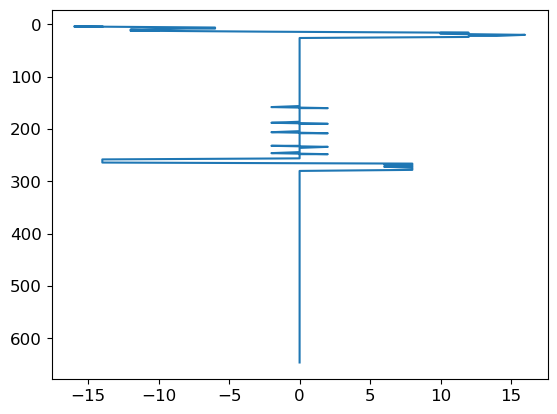

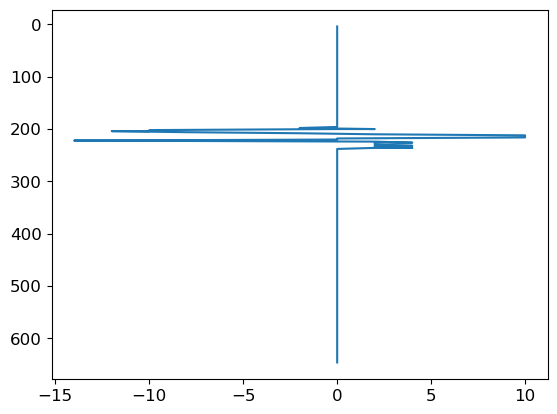

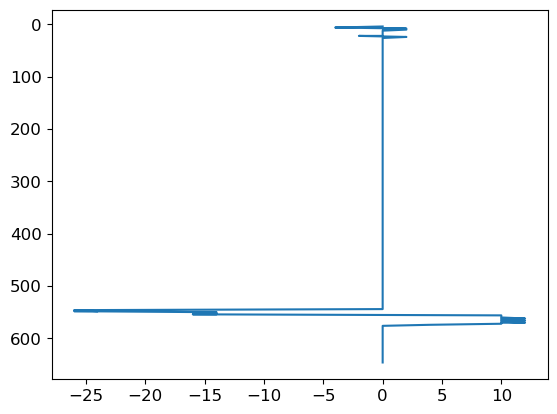

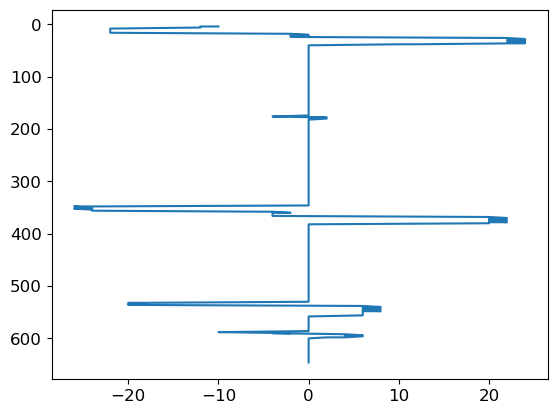

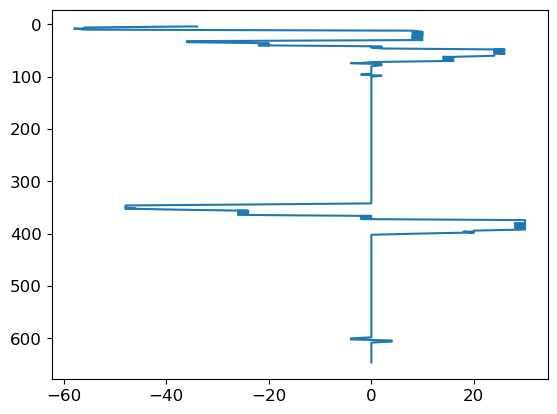

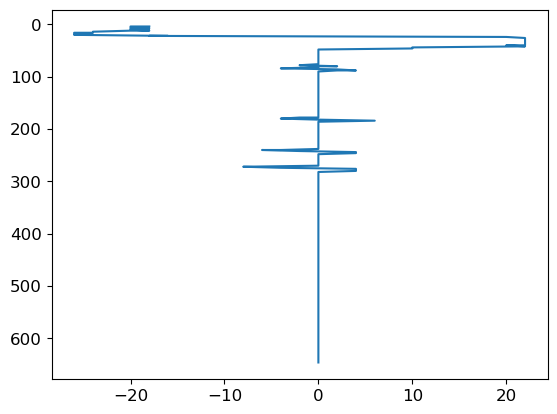

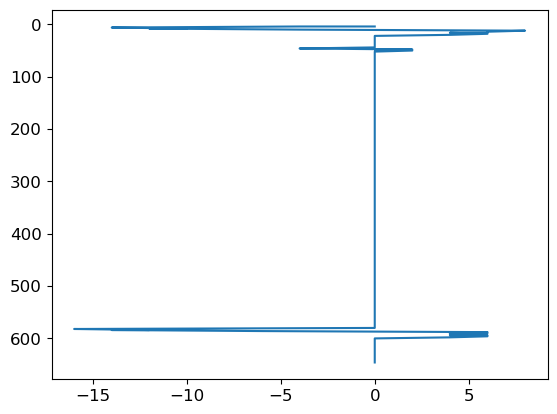

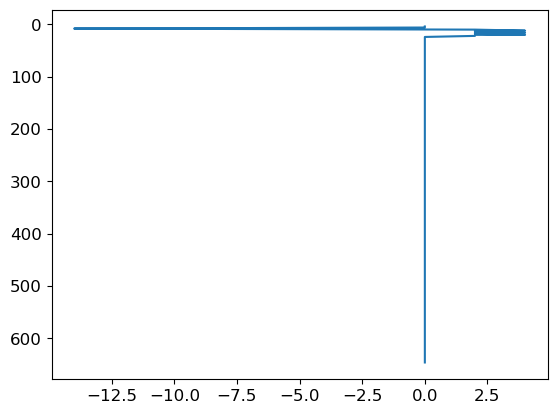

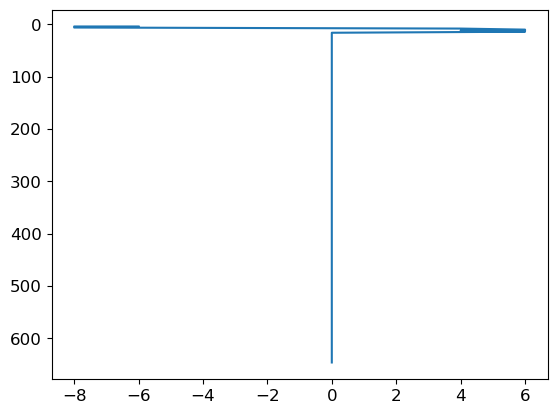

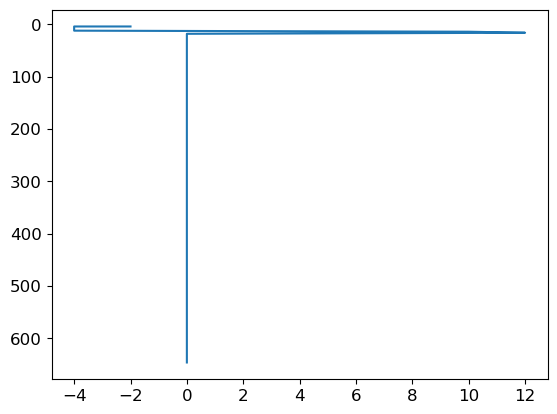

In [72]:
for cast in P:
    plt.plot((thorpe[cast]), depth)
    plt.gca().invert_yaxis()
    plt.show()

In [11]:
def calc_N2(density, depth): #  calculate buoyancy frequency with density gradient
    g = 9.81
    ref_den = 1020
    p_grad = np.gradient(density, depth)
    N2 = (g / ref_den) * p_grad
    return pd.DataFrame(N2)
    
def calc_shear(u, v, depth): # calculate shear from u and z
    shear_u = np.gradient(u, depth)
    shear_v = np.gradient(v, depth)
    shear = np.sqrt(shear_u**2 + shear_v**2)
    return pd.DataFrame(shear)
    
def calc_rich(N2, shear): # calculate richardson numbers from buoyancy frequency squared and 
    rich = N2 / (shear**2)
    return pd.DataFrame(rich)

def calc_mix(density, depth, u, v):
    # N2
    N2_list = []
    for col in range(len(density.columns)):
        N2_col = calc_N2(density.iloc[:, col], depth.iloc[:, 0])
        N2_list.append(N2_col)

    N2 = pd.concat(N2_list, axis=1)

    # shear
    shear_list = []
    for col in range(len(u.columns)):
        shear_col = calc_shear(u.iloc[:, col], v.iloc[:, col], depth.iloc[:, 0])
        shear_list.append(shear_col)
    shear = pd.concat(shear_list, axis=1)

    # richardson
    ri_list = []
    for col in range(len(N2.columns)):
        ri_col = calc_rich(N2.iloc[:, col], shear.iloc[:, col])
        ri_list.append(ri_col)
    ri = pd.concat(ri_list, axis=1)
    
    return N2, shear, ri

In [12]:
def bin_average(list, num_bins): # a sub_function that bin-averages a list of data
    _, bin_edges = np.histogram(np.arange(len(list)), bins=num_bins) # bin data
    b_avg = [np.mean(list[int(start):int(end)]) for start, end in zip(bin_edges[:-1], bin_edges[1:])] # avg data by bin
    return b_avg

def df_bin_average(df, num_bins):
    binned_data = {}
    for column_idx in df.columns:
        binned_data[column_idx] = bin_average(np.array(df[column_idx]), num_bins)

    return pd.DataFrame(binned_data)

# vertical binning
num_bins = int(40)
P_bin_y = df_bin_average(P_int, num_bins)
T_bin_y = df_bin_average(T_int, num_bins)
S_bin_y = df_bin_average(S_int, num_bins)
D_bin_y = df_bin_average(D_int, num_bins)
lat_bin_y = df_bin_average(lat_matrix, num_bins)


# horizontal binning
num_bins = int(709)
P_binned = df_bin_average(P_bin_y.T, num_bins).T
T_binned = df_bin_average(T_bin_y.T, num_bins).T
S_binned = df_bin_average(S_bin_y.T, num_bins).T
D_binned = df_bin_average(D_bin_y.T, num_bins).T
lat_binned = df_bin_average(lat_bin_y.T, num_bins).T

# adcp
u = pd.DataFrame(ADCP['u'])
v = pd.DataFrame(ADCP['v'])
z = pd.DataFrame(ADCP['z'])

In [13]:
N2, shear, ri = calc_mix(D_binned, P_binned, u, v)  

In [14]:
print(np.shape(N2))
print(np.shape(shear))
print(np.shape(ri))

(40, 709)
(40, 709)
(40, 709)


In [15]:
mask = np.logical_and(ri <= 0.25, ri > 0)
ri_count = np.sum(np.sum(mask))
print('> 0.25 richardson count > 0:')
print(ri_count)

mask = ri <= 0.25
ri_count = np.sum(np.sum(mask))
print('> 0.25 richardson count:')
print(ri_count)

> 0.25 richardson count > 0:
1488
> 0.25 richardson count:
1594


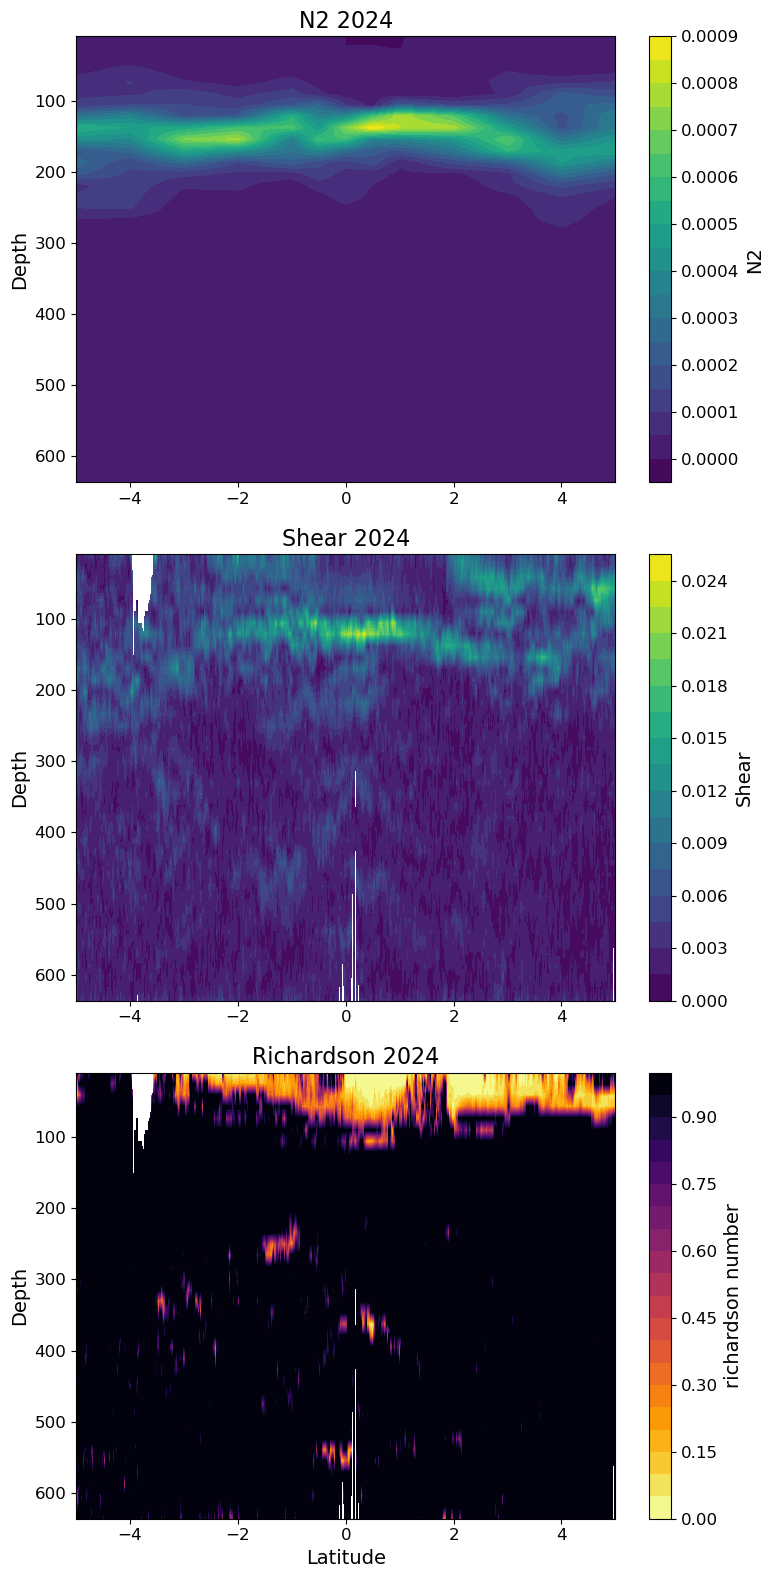

In [16]:
plt.figure(figsize=(8, 16))
plt.subplot(311)
contour_N2 = plt.contourf(lat_binned, P_binned, N2, levels=20)
plt.gca().invert_yaxis()
plt.colorbar(contour_N2, label='N2')
plt.ylabel('Depth')
plt.title('N2 2024')

# Plot shear
plt.subplot(312)
contour_shear = plt.contourf(lat_binned, P_binned, shear, levels=20)
plt.gca().invert_yaxis()
plt.colorbar(contour_shear, label='Shear')
plt.ylabel('Depth')
plt.title('Shear 2024')

# Plot Richardson
visualize_ri = ri.clip(lower=0, upper=1) # aide visualization

plt.subplot(313)
contour_ri = plt.contourf(lat_binned, P_binned, visualize_ri, levels=20, cmap='inferno_r')
plt.gca().invert_yaxis()
plt.colorbar(contour_ri, label='richardson number')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.title('Richardson 2024')


# Adjust layout
plt.tight_layout()

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [37]:
P_flat =  pd.DataFrame({'P':np.nan_to_num(P_binned.values.flatten())})
T_flat =  pd.DataFrame({'T':np.nan_to_num(T_binned.values.flatten())})
S_flat =  pd.DataFrame({'S':np.nan_to_num(S_binned.values.flatten())})
D_flat =  pd.DataFrame({'D':np.nan_to_num(D_binned.values.flatten())})
N2_flat = pd.DataFrame({'N2':np.nan_to_num(N2.values.flatten())})
shear_flat = pd.DataFrame({'shear':np.nan_to_num(shear.values.flatten())})
ri_flat = pd.DataFrame({'ri':np.nan_to_num(ri.values.flatten())})
u_flat = pd.DataFrame({'u':np.nan_to_num(u_binned.values.flatten())})
v_flat = pd.DataFrame({'v':np.nan_to_num(v_binned.values.flatten())})
pca_features = [P_flat, T_flat, S_flat, D_flat, N2_flat, u_flat]
pca_df = pd.concat(pca_features, axis = 1)

In [38]:
# PCA

# Select the features for PCA
features = ['P', 'T', 'S', 'D', 'N2', 'u']

# Extract the selected features from the concatenated dataframe
X = pca_df[features]

X.fillna(X.mean(), inplace=True)

# Replace infinite values with a large finite value or use a different strategy
X.replace([np.inf, -np.inf],100000 , inplace=True)


# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)  # You can choose the number of principal components
principalComponents = pca.fit_transform(X_scaled)

# Creating a DataFrame with the principal components
columns = [f'PC{i}' for i in range(1, pca.n_components_ + 1)]
principalDf = pd.DataFrame(data=principalComponents, columns=columns)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Sum of explained variance ratios:", np.sum(explained_variance))

Explained variance ratio: [0.65142046 0.18243933 0.10777069]
Sum of explained variance ratios: 0.9416304772728354


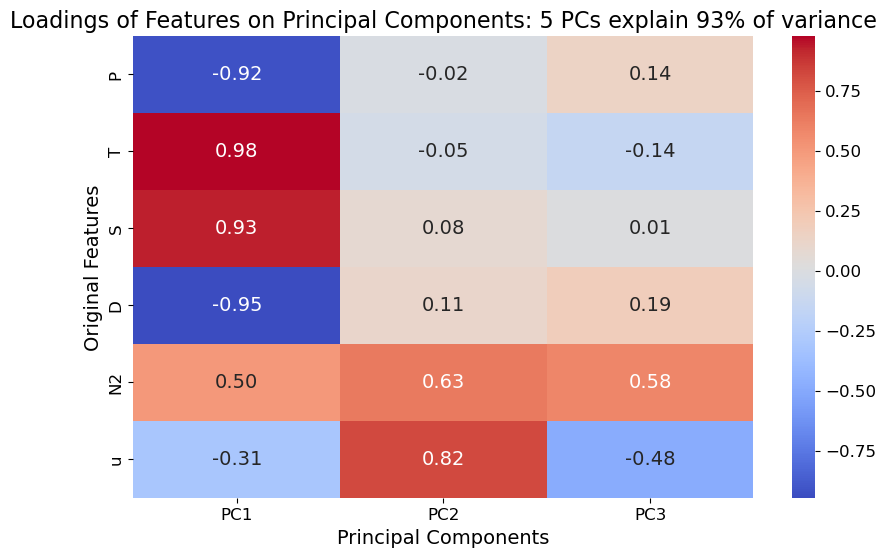

In [39]:
import seaborn as sns
# Calculating loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Creating a DataFrame with loadings
loadings_df = pd.DataFrame(loadings, columns=columns, index=features)

# Create a heatmap for the loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Loadings of Features on Principal Components: 5 PCs explain 93% of variance')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

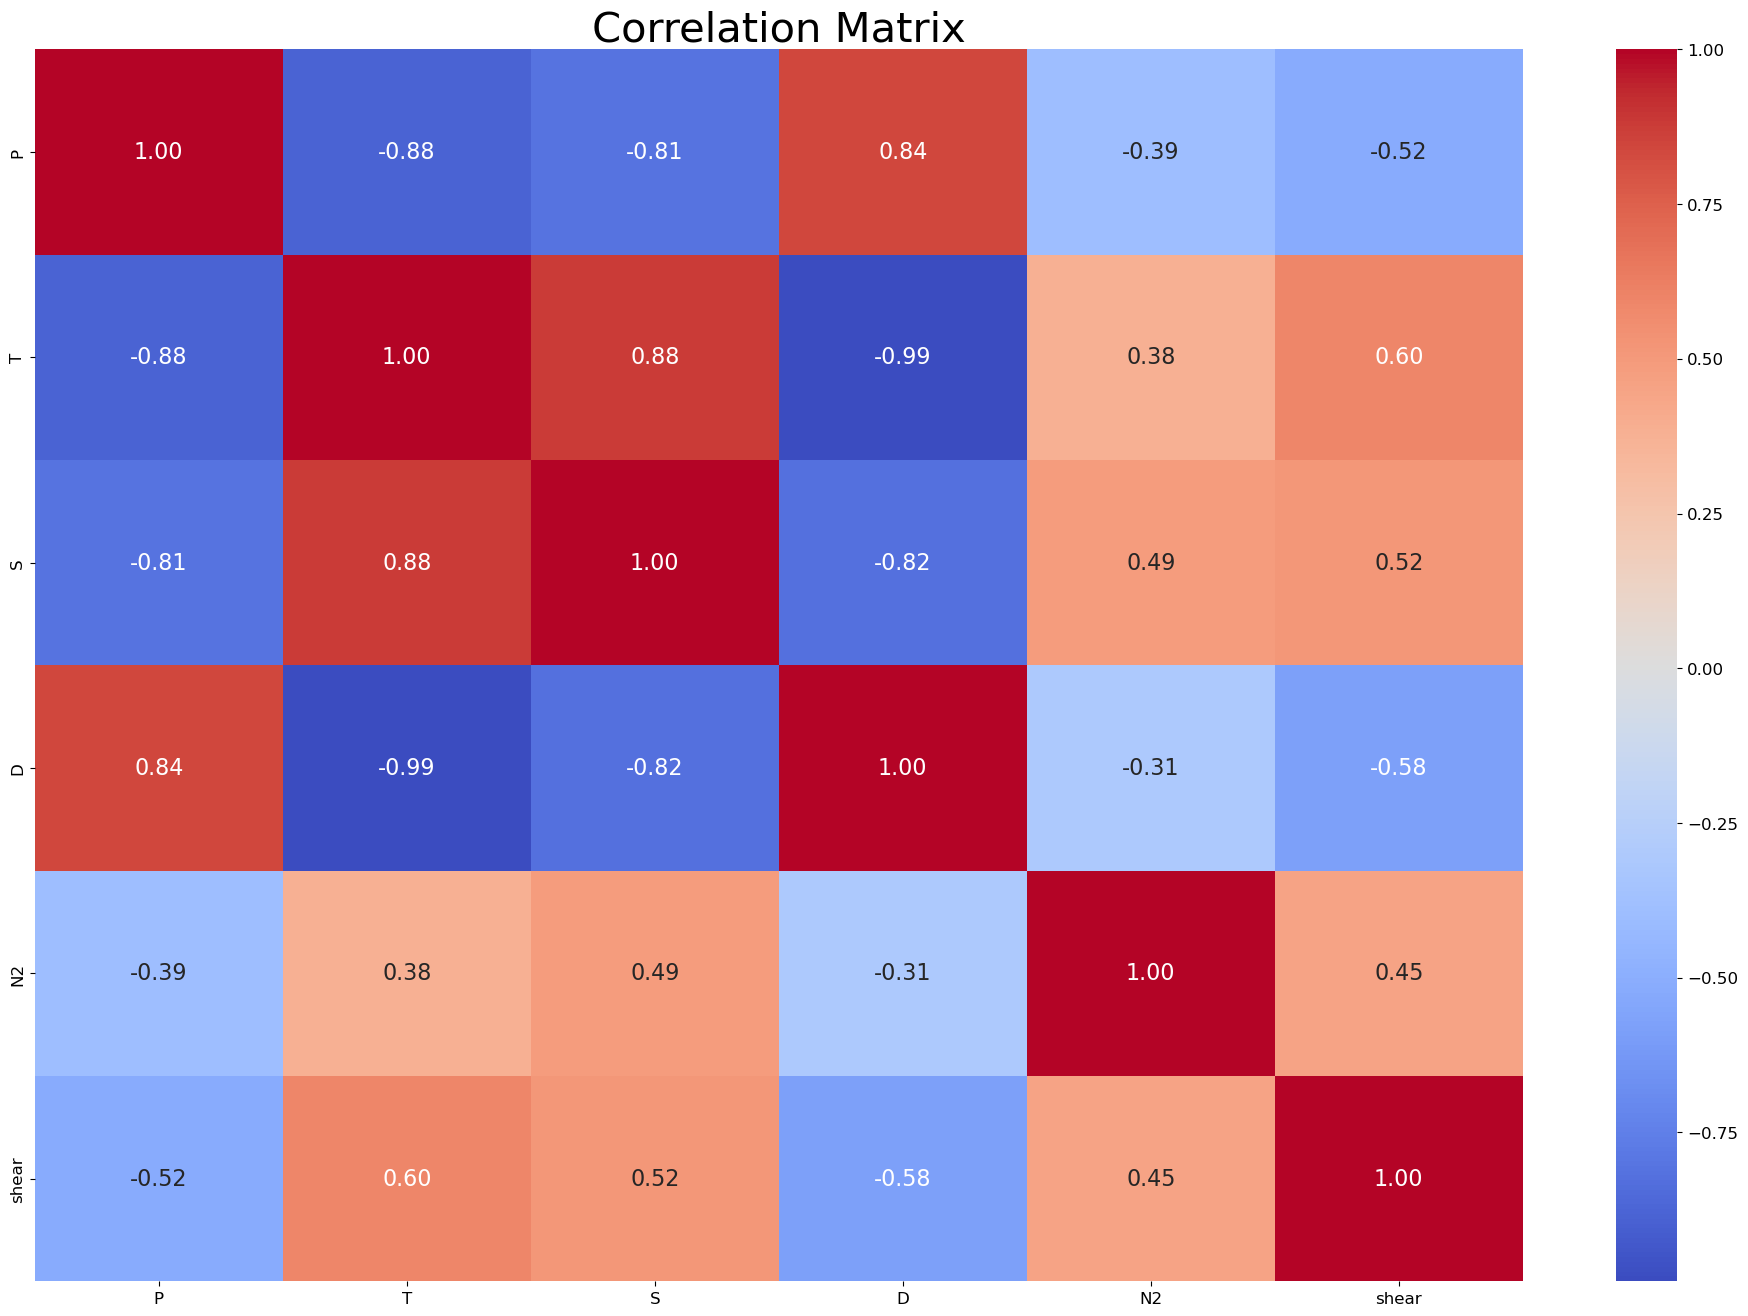

In [33]:
correlation_matrix = pca_df.corr()
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 16})
plt.title('Correlation Matrix',fontsize=30)
#plt.savefig(path + 'Correlation Matrix.png', bbox_inches='tight')
plt.show()